In [199]:
%matplotlib inline
import numpy as np

import scipy.stats as stat
import scipy.integrate as pyint
import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib import cm

# Unfolding
## Exercise 1
### Part a

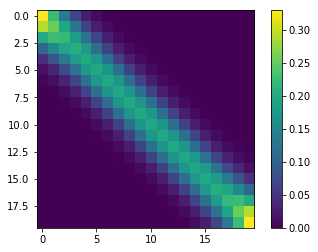

In [200]:
Nbins = 20
bin_edges = np.linspace(0,100,Nbins+1)
sigma = 2*(bin_edges[1]-bin_edges[0])
c_norm = 1./(np.sqrt(2)*sigma*pyint.quad(lambda x: np.exp(-x**2),0,100)[0])
def res_function(x,y):
    return np.exp(-(x-y)**2/(2*sigma**2))/pyint.quad(lambda x: np.exp(-(x-y)**2/(2*sigma**2)),0,100)[0]

def int_res_fun(y,xa,xb):
    return pyint.quad(lambda x: res_function(x,y),xa,xb)[0]

bin_midpoint = .5*(bin_edges[1:]+bin_edges[:-1])
R_matrix = np.empty((Nbins,Nbins))
for i in range(Nbins):
    for j in range(Nbins):
        R_matrix[i,j]=int_res_fun(bin_midpoint[j],bin_edges[i],bin_edges[i+1])
        
plt.imshow(R_matrix)
plt.colorbar()

### Part b

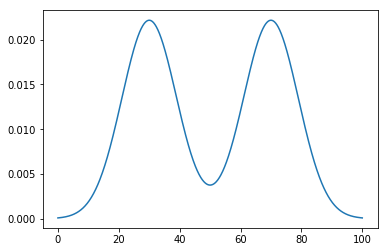

In [3]:
sigma_data = 9
#c_data = 1./(np.sqrt(2)*sigma_data*pyint.quad(lambda x: np.exp(-x**2),0,100)[0])

def f_true(x):
    return (np.exp(-(x-30)**2/(2*sigma_data**2))+np.exp(-(x-70)**2/(2*sigma_data**2)))/pyint.quad(lambda x: (np.exp(-(x-30)**2/(2*sigma_data**2))+np.exp(-(x-70)**2/(2*sigma_data**2))),0,100)[0]

x_plot = np.linspace(0,100,1000)
plt.plot(x_plot,f_true(x_plot))

In [4]:
mutot=100000
p=np.zeros(Nbins)
for i in range(Nbins):
    p[i]=pyint.quad(lambda x: f_true(x),bin_edges[i],bin_edges[i+1])[0]
    
mu_hist=mutot*p   

<Container object of 20 artists>

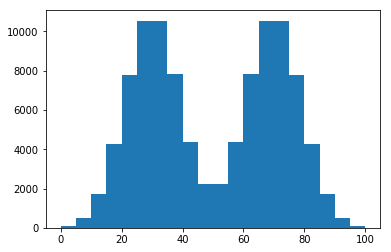

In [5]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0])

<Container object of 20 artists>

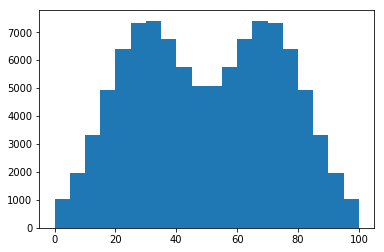

In [6]:
nu_hist = np.dot(R_matrix,mu_hist)
plt.bar(bin_midpoint,nu_hist,width=bin_edges[1]-bin_edges[0])

<Container object of 20 artists>

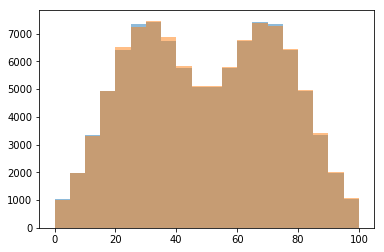

In [7]:
N_d = len(nu_hist)
poisson = stat.poisson(nu_hist)
Nexperiment_d = poisson.rvs(N_d)
plt.figure()
plt.bar(bin_midpoint,nu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5)
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5)

### Part e

<Container object of 20 artists>

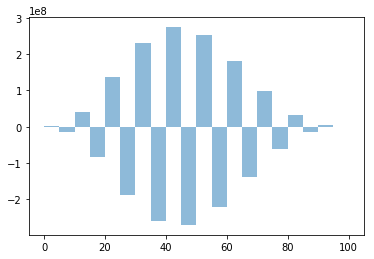

In [8]:
R_inv = np.linalg.inv(R_matrix)
mu_estimated_inv = np.dot(R_inv,Nexperiment_d)
plt.figure()
plt.bar(bin_midpoint,mu_estimated_inv,width=bin_edges[1]-bin_edges[0],alpha=0.5)
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5)

### Part f

In [17]:
def chi2_mu_hist(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = (nu_hist_try-Nexperiment_d)**2/nu_hist_try
    return sum(logp_i)

#bound_f = tuple([(0,None) for i in range(N_d)]) No usar bounds
minimization_chi = opt.minimize(chi2_mu_hist,mu_estimated_inv)#,bounds=bound_f)
mu_estimated_chi = minimization_chi['x']

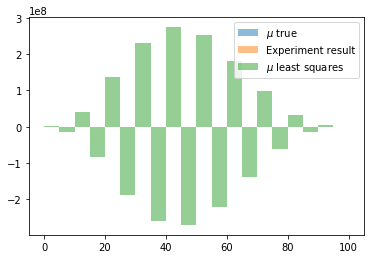

In [18]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'Experiment result')
plt.bar(bin_midpoint,mu_estimated_chi,width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ least squares')
plt.legend()

In [21]:
def like_mu_hist(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = -np.log(nu_hist_try)*Nexperiment_d+(Nexperiment_d*np.log(Nexperiment_d)-Nexperiment_d)+nu_hist_try
    return np.sum(logp_i)

#bound_f = tuple([(0,None) for i in range(N_d)]) #No usar bounds
minimization_like = opt.minimize(like_mu_hist,mu_estimated_inv)#,bounds=bound_f)
mu_estimated_like = minimization_like['x']

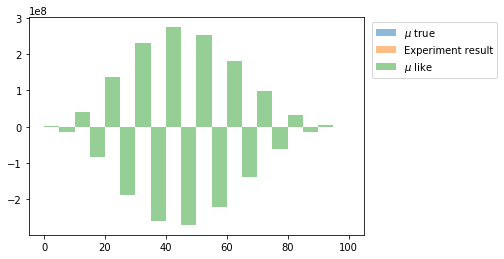

In [22]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,Nexperiment_d,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'Experiment result')
plt.bar(bin_midpoint,mu_estimated_like,width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ like')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

## Correction factors
It s based on an iteration that does not converge! Yay!

In [23]:
N_g = 10
mus_g = np.empty((N_g+1,len(Nexperiment_d)))
nus_g = np.empty((N_g,len(Nexperiment_d)))
mus_g[0,:] = Nexperiment_d
for i in range(N_g):
    nus_g[i,:] = np.dot(R_matrix,mus_g[i,:])
    c = mus_g[i,:]/nus_g[i,:]
    mus_g[i+1,:] = c*Nexperiment_d

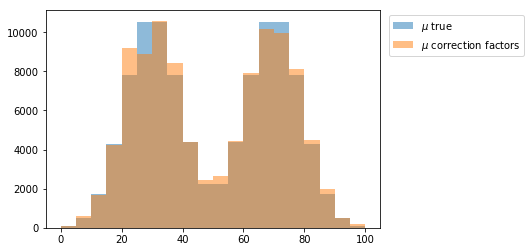

In [24]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,mus_g[-1,:],width=bin_edges[1]-bin_edges[0],alpha=0.5, label= '$\mu$ correction factors')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

## Forward unfolding

In [25]:
def f_param(x,theta):
    mean1,mean2,s1,s2,norm = theta
    return norm*(np.exp(-(x-mean1)**2/(2*s1**2))+np.exp(-(x-mean2)**2/(2*s2**2)))

def chi2_forward(theta):
    nu_i = np.dot(R_matrix,f_param(bin_midpoint,theta))
    chi = (nu_i-Nexperiment_d)**2/Nexperiment_d
    return sum(chi)

In [26]:
minimization_fow = opt.minimize(chi2_forward,(20,60,5,15,5000))
theta_estimated_fow = minimization_fow['x']
print(theta_estimated_fow)

[  3.01542655e+01   7.01355255e+01   9.20790123e+00   9.14745259e+00
   1.09250190e+04]


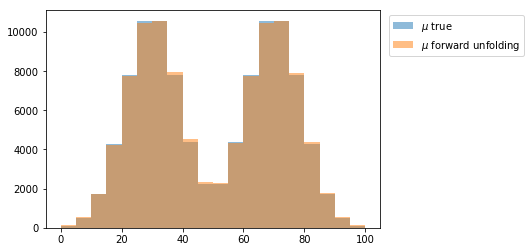

In [27]:
plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
plt.bar(bin_midpoint,f_param(bin_midpoint,theta_estimated_fow),width=bin_edges[1]-bin_edges[0],
        alpha=0.5, label= '$\mu$ forward unfolding')
plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

# Exercise 2

## Part a
Done in ex1
## Part b
we are going to use maximum entropy
## Part c

In [28]:
def s_mu_eq7(mu_try):
    mu_tot = sum(mu_try)
    p = mu_try/mu_tot
    return -sum(p*np.log(p))

n_tot = sum(Nexperiment_d)
def eq7_max_entropy(mu_try,alpha,landa):
    return -alpha*like_mu_hist(mu_try)+s_mu_eq7(mu_try)+landa*(sum(np.dot(R_matrix,mu_try))-n_tot)

In [29]:
alphavec = np.logspace(-1,12,50)
mus_reg = np.empty((len(alphavec),len(Nexperiment_d)))
lambdas_reg = np.empty(len(alphavec))
bound_f = tuple([(0,None) for i in range(N_d)]+[(None,None)])
for i,alpha in enumerate(alphavec):
    res_alph = opt.minimize(lambda mulanda: -eq7_max_entropy(mulanda[:-1],alpha,mulanda[-1]),
                            np.append(Nexperiment_d,5),bounds=bound_f)
    mus_reg[i,:] = res_alph['x'][:-1]
    lambdas_reg[i] = res_alph['x'][-1]

C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [20]:
#np.savetxt('mus_reg_2.dat',mus_reg)
#np.savetxt('alphas_reg_2.dat',alphavec)
#np.savetxt('lambdas_reg_2.dat',lambdas_reg)

In [21]:
#mus_reg = np.loadtxt('mus_reg_2.dat')
#alphavec = np.loadtxt('alphas_reg_2.dat')
#lambdas_reg = np.loadtxt('lambdas_reg_2.dat')

## Part d

In [21]:
# Alternative way of defining A and B for maximum entropy
V = np.eye(N_d)*Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=1)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=1)
Rprod = np.empty((N_d,N_d,N_d))

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

for k,alpha in enumerate(alphavec):
    mutot=sum(mus_reg[k,:])
    mutot2 = mutot**2
    p_k = mus_reg[k,:]/mutot
    entropy = -2*sum(p_k*np.log(p_k))
    nu_k = np.dot(R_matrix,mus_reg[k,:])
    nu_k2 = nu_k**2
    Bopt[:N_d,:] = R_matrix/(ones*nu_k)
    for i in range(N_d):
        Aopt[i,i] = -alpha*sum(Rprod[i,i,:]/nu_k2)+\
                    (1.-mutot/mus_reg[k,i]+np.log(mus_reg[k,i]*p_k[i])+entropy)/mutot**2
        ai = -alpha*np.sum(Rprod[i,:i,:]/nu_k2,axis=1)+(1.+np.log(mus_reg[k,i]*p_k[:i])+entropy)/mutot2
        Aopt[i,:i] = ai
        Aopt[:i,i] = ai

    C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
    U = np.dot(np.dot(C,V),np.transpose(C))

Tychonof S

In [45]:
Gdiag6 = np.diag(6*np.ones(N_d))
Gdiag4 = np.diag(-4*np.ones(N_d-1),k=1)
Gdiag1 = np.diag(np.ones(N_d-2),k=2)
G=Gdiag6+Gdiag4+Gdiag4.transpose()+Gdiag1+Gdiag1.transpose()
G[0,0]=1
G[-1,-1]=1
G[1,1]=5
G[-2,-2]=5
G[0,1]=-2
G[1,0]=-2
G[-1,-2]=-2
G[-2,-1]=-2

def s_mu_tycho(mu_try):
    return -np.dot(mu_try,np.dot(G,mu_try))


def like_mu(mu_hist_try):
    nu_hist_try = np.dot(R_matrix,mu_hist_try)
    logp_i = np.log(nu_hist_try)*Nexperiment_d-(Nexperiment_d*np.log(Nexperiment_d)-Nexperiment_d)-nu_hist_try
    return np.sum(logp_i)

n_tot = sum(Nexperiment_d)
def eq7_tycho(mu_try,alpha,landa):
    return alpha*like_mu(mu_try)+s_mu_tycho(mu_try)+landa*(sum(np.dot(R_matrix,mu_try))-n_tot)

(20L, 20L)


In [224]:
alphavec = np.logspace(np.log10(3e5),np.log10(3e6),500)
mus_reg = np.empty((len(alphavec),len(Nexperiment_d)))
lambdas_reg = np.empty(len(alphavec))

bnd = tuple([(1e-5,None) for i in range(N_d)]+[(None,None)]) 
for i,alpha in enumerate(alphavec):
    res_alph = opt.minimize(lambda mulanda: -eq7_tycho(mulanda[:-1],alpha,mulanda[-1]),
                            np.append(Nexperiment_d,5),bounds=bnd)
    mus_reg[i,:] = res_alph['x'][:-1]
    #print np.any(mus_reg[i,:]==0), np.any(mus_reg[i,:]<0)
    lambdas_reg[i] = res_alph['x'][-1]


In [225]:
Lmax = like_mu(mu_estimated_inv)
V = np.eye(N_d)*Nexperiment_d
Vinv = np.eye(N_d)/Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
iden = np.identity(N_d)
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=0)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=0)

Rprod = np.empty((N_d,N_d,N_d))
MSE = np.empty_like(alphavec)
MSEprime = np.empty_like(alphavec)
chieff = np.empty_like(alphavec)
chib = np.empty_like(alphavec)
R = R_matrix
DeltaL = np.empty_like(alphavec)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

for k,alpha in enumerate(alphavec):
    DeltaL[k] = Lmax-like_mu(mus_reg[k,:])
    mutot=sum(mus_reg[k,:])
    mutot2 = mutot**2
    p_k = mus_reg[k,:]/mutot
    entropy = -2*sum(p_k*np.log(p_k))
    nu_k = np.dot(R_matrix,mus_reg[k,:])
    nu_k2 = nu_k**2
    Bopt[:N_d,:] = alpha*R_matrix/(ones*nu_k)
    for i in range(N_d):
        Aopt[i,:N_d] = -alpha*np.sum(Rprod[i,:,:]/nu_k2,axis=1)-2*G[i,:]

    C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
    U = np.dot(np.dot(C,V),np.transpose(C))
    bias = np.dot(C,(nu_k-Nexperiment_d))
    
    bias2 = bias**2
    MSEnum = np.diag(U)+bias2
    MSE[k] = np.sum(MSEnum)/N_d
    MSEprime[k] = np.sum(MSEnum/mus_reg[k,:])/N_d
    RC = np.dot(R,C)
    CR = np.dot(C,R)
    nu_n = nu_k-Nexperiment_d
    nu_n_RC = np.dot(nu_n,RC)
    chieff[k] = np.dot(np.dot(nu_n_RC,Vinv),nu_n_RC.transpose())
    W = np.dot(np.dot((CR-iden),U),(CR-iden).transpose())
    chib[k] = np.sum(bias2/np.diag(W))/N_d


58873.0873352
[265]
alpha =  [1019021.575]
DeltaL =  [5.332]
165.95834223
(array([421], dtype=int64),)


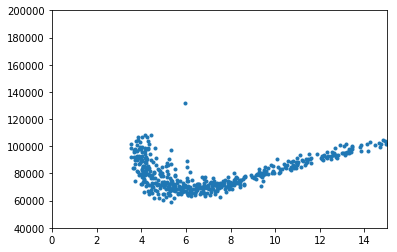

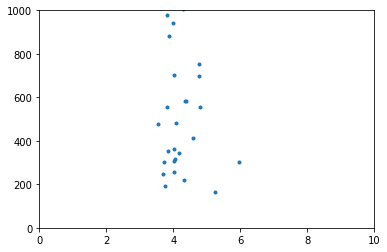

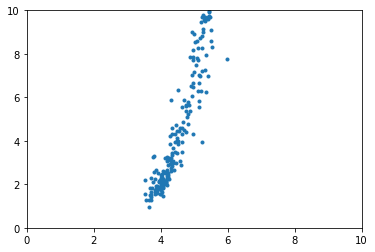

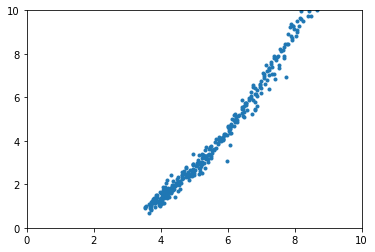

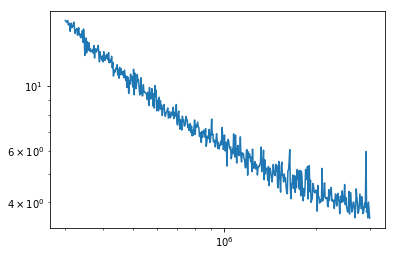

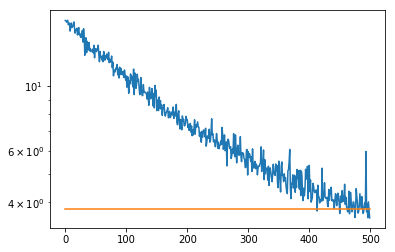

In [226]:
indexs = np.argsort(DeltaL)
plt.figure()
plt.plot(DeltaL,MSE,'.')
plt.xlim([0,15])
plt.ylim([4e4,2e5])
print(min(MSE))
print(np.where(MSE==min(MSE))[0])
print 'alpha = ',alphavec[np.where(MSE==min(MSE))[0]]
print 'DeltaL = ',DeltaL[np.where(MSE==min(MSE))[0]]
plt.figure()
plt.plot(DeltaL,MSEprime,'.')
plt.xlim([0,10])
plt.ylim([0,1e3])
print(min(MSEprime))
print(np.where(MSEprime==min(MSEprime)))

plt.figure()
plt.plot(DeltaL,chieff,'.')
plt.xlim([0,10])
plt.ylim([0,1e1])

plt.figure()
plt.plot(DeltaL,chib,'.')
plt.xlim([0,10])
plt.ylim([0,1e1])

plt.figure()
plt.loglog(alphavec,DeltaL)

plt.figure()
plt.semilogy(DeltaL)
plt.semilogy(np.ones(len(DeltaL))*3.8)

Nos interesan los valores de $\Delta\log L = 3.8-4$ (para las $\chi^2$), que corresponden a las posiciones en el vector alrededor de 470-490

In [227]:
def plot_hist_err(mu,mu_err,mu_bias,bias_err):
    plt.figure()
    plt.bar(bin_midpoint,mu_hist,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ true')
    plt.bar(bin_midpoint,mu,width=bin_edges[1]-bin_edges[0],alpha=0.5,label=r'$\mu$ regularization')
    plt.errorbar(bin_midpoint,mu,mu_err,fmt='k_',ms=10)
    plt.xlabel('$x$')
    plt.legend(loc=2,bbox_to_anchor=(1.01, 1))
    plt.figure()
    plt.plot(np.linspace(-10,110),np.zeros(50),'--',color='xkcd:brown grey')
    plt.errorbar(bin_midpoint,mu_bias,bias_err,label='Estimated bias',fmt='k_',ms=15)
    plt.xlim([0,100])
    plt.xlabel('$x$')
    plt.legend(loc=2,bbox_to_anchor=(1.01, 1))

265


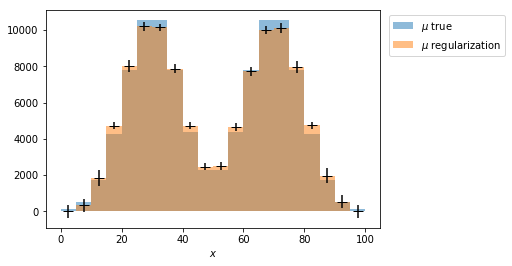

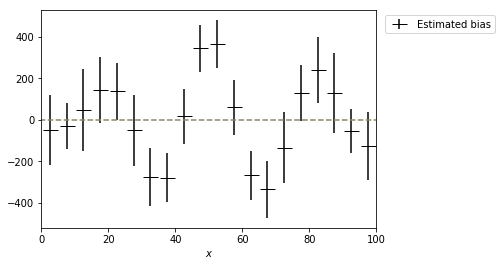

In [232]:
# MSE
k_MSE = np.where(MSE==min(MSE))[0][0]
print k_MSE
alpha_MSE = alphavec[k_MSE]
DeltaL_MSE = DeltaL[k_MSE]
V = np.eye(N_d)*Nexperiment_d
Vinv = np.eye(N_d)/Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
iden = np.identity(N_d)
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=0)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=0)

Rprod = np.empty((N_d,N_d,N_d))
R = R_matrix

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

mu_MSE = mus_reg[k_MSE,:]
mutot=sum(mu_MSE)
mutot2 = mutot**2
nu_k = np.dot(R_matrix,mu_MSE)
nu_k2 = nu_k**2
Bopt[:N_d,:] = alpha*R_matrix/(ones*nu_k)
for i in range(N_d):
    Aopt[i,:N_d] = -alpha*np.sum(Rprod[i,:,:]/nu_k2,axis=1)-2*G[i,:]

C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
U_MSE = np.dot(np.dot(C,V),np.transpose(C))
bias_MSE = np.dot(C,(nu_k-Nexperiment_d))
CR = np.dot(C,R)
W_MSE = np.dot(np.dot((CR-iden),U),(CR-iden).transpose())

plot_hist_err(mu_MSE,np.sqrt(np.diag(U_MSE)),bias_MSE,np.sqrt(np.diag(W_MSE)))

421


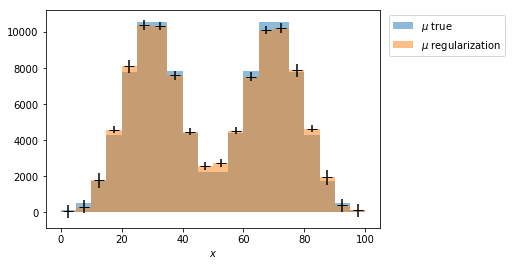

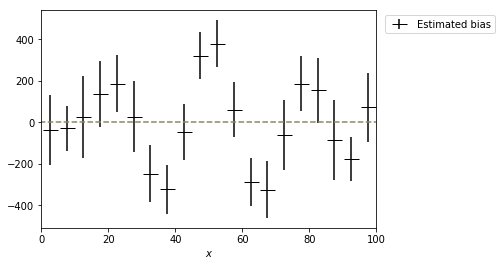

In [234]:
# MSE'
k_MSEp = np.where(MSEprime==min(MSEprime))[0][0]
print k_MSEp
alpha_MSEp = alphavec[k_MSEp]
DeltaL_MSEp = DeltaL[k_MSEp]
V = np.eye(N_d)*Nexperiment_d
Vinv = np.eye(N_d)/Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
iden = np.identity(N_d)
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=0)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=0)

Rprod = np.empty((N_d,N_d,N_d))
R = R_matrix

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

mu_MSEp = mus_reg[k_MSEp,:]
mutot=sum(mu_MSEp)
mutot2 = mutot**2
nu_k = np.dot(R_matrix,mu_MSEp)
nu_k2 = nu_k**2
Bopt[:N_d,:] = alpha*R_matrix/(ones*nu_k)
for i in range(N_d):
    Aopt[i,:N_d] = -alpha*np.sum(Rprod[i,:,:]/nu_k2,axis=1)-2*G[i,:]

C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
Up = np.dot(np.dot(C,V),np.transpose(C))
biasp = np.dot(C,(nu_k-Nexperiment_d))
CR = np.dot(C,R)
Wp = np.dot(np.dot((CR-iden),U),(CR-iden).transpose())

plot_hist_err(mu_MSEp,np.sqrt(np.diag(Up)),biasp,np.sqrt(np.diag(Wp)))

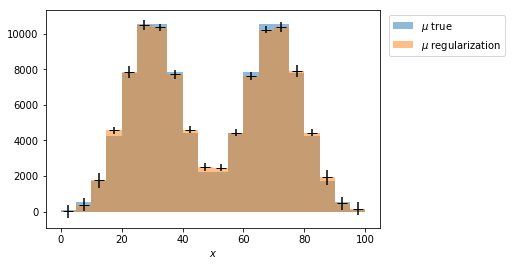

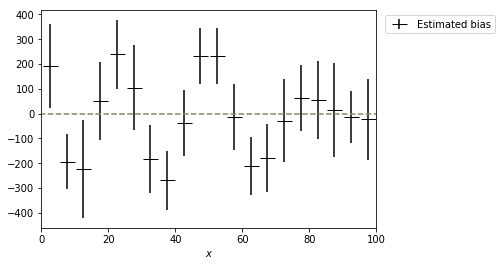

In [236]:
# chi eff
k_eff = 490
alpha_eff = alphavec[k_eff]
DeltaL_eff = DeltaL[k_eff]
V = np.eye(N_d)*Nexperiment_d
Vinv = np.eye(N_d)/Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
iden = np.identity(N_d)
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=0)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=0)

Rprod = np.empty((N_d,N_d,N_d))
R = R_matrix

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

mu_eff = mus_reg[k_eff,:]
mutot=sum(mu_eff)
mutot2 = mutot**2
nu_k = np.dot(R_matrix,mu_eff)
nu_k2 = nu_k**2
Bopt[:N_d,:] = alpha*R_matrix/(ones*nu_k)
for i in range(N_d):
    Aopt[i,:N_d] = -alpha*np.sum(Rprod[i,:,:]/nu_k2,axis=1)-2*G[i,:]

C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
Ueff = np.dot(np.dot(C,V),np.transpose(C))
biaseff = np.dot(C,(nu_k-Nexperiment_d))
CR = np.dot(C,R)
Weff = np.dot(np.dot((CR-iden),U),(CR-iden).transpose())

plot_hist_err(mu_eff,np.sqrt(np.diag(Ueff)),biaseff,np.sqrt(np.diag(Weff)))

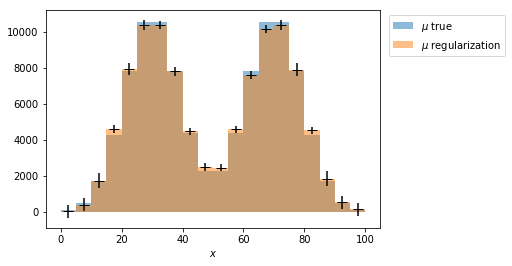

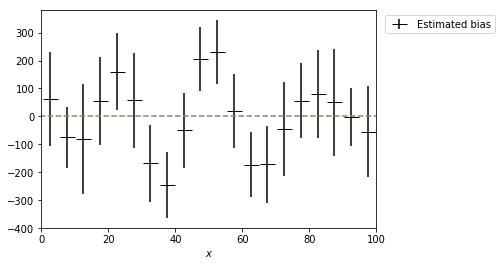

In [237]:
# chi eff
k_b = 470
alpha_b = alphavec[k_b]
DeltaL_b = DeltaL[k_b]
V = np.eye(N_d)*Nexperiment_d
Vinv = np.eye(N_d)/Nexperiment_d
Aopt = np.zeros((N_d+1,N_d+1))
Bopt = np.ones((N_d+1,N_d))
ones = np.ones((N_d,N_d))
iden = np.identity(N_d)
Aopt[:N_d,N_d] = -np.sum(R_matrix,axis=0)
Aopt[N_d,:N_d] = -np.sum(R_matrix,axis=0)

Rprod = np.empty((N_d,N_d,N_d))
R = R_matrix

for i in range(N_d):
    for j in range(N_d):
        Rprod[i,j,:] = Nexperiment_d*R_matrix[:,i]*R_matrix[:,j]

mu_b = mus_reg[k_b,:]
mutot=sum(mu_b)
mutot2 = mutot**2
nu_k = np.dot(R_matrix,mu_b)
nu_k2 = nu_k**2
Bopt[:N_d,:] = alpha*R_matrix/(ones*nu_k)
for i in range(N_d):
    Aopt[i,:N_d] = -alpha*np.sum(Rprod[i,:,:]/nu_k2,axis=1)-2*G[i,:]

C = -np.dot(np.linalg.inv(Aopt),Bopt)[:N_d,:]
Ub = np.dot(np.dot(C,V),np.transpose(C))
biasb = np.dot(C,(nu_k-Nexperiment_d))
CR = np.dot(C,R)
Wb = np.dot(np.dot((CR-iden),U),(CR-iden).transpose())

plot_hist_err(mu_b,np.sqrt(np.diag(Ub)),biasb,np.sqrt(np.diag(Wb)))

Expected computation time with opt version is 8.2 s
Expected computation time with standard version is 137.0 s


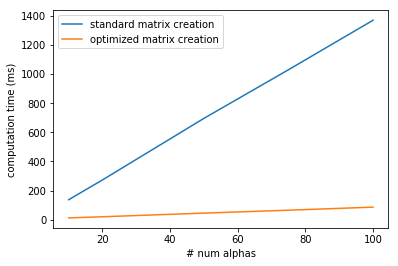

In [194]:
t = [137 , 273 , 696 , 1030 , 1370]
topt = [12 , 20 , 45 , 65 , 86]
n = [10, 20 , 50 , 75 , 100]
plt.plot(n,t,label='standard matrix creation')
plt.plot(n,topt,label='optimized matrix creation')
plt.legend()
plt.xlabel('# num alphas')
plt.ylabel('computation time (ms)')
print 'Expected computation time with opt version is %.1f s' %((topt[-1]-topt[0])*1./(n[-1]-n[0])*10)
print 'Expected computation time with standard version is %.1f s' %((t[-1]-t[0])*1./(n[-1]-n[0])*10)